<a href="https://colab.research.google.com/github/Callmerakha/Quantum-Computing-Project/blob/main/the_QUANTUM_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QCNN in QUANTUM COMPUTING

based on claude.ai
https://claude.ai/chat/f44e306e-c422-4ab5-ad85-ebee75ee27d0

Meginstall Qiskit dan beberapa keperluan lain untuk QCNN

In [ ]:
!pip install qiskit pennylane pennylane-qiskit torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 758.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 14.3

mengengcek apakah sudah terintall dengan baik atau beluman dengang mengecek versinya

In [ ]:
# prompt: grab the version

import qiskit
import pennylane
import torch
import torchvision
import matplotlib

print("Qiskit version:", qiskit.__version__)
print("PennyLane version:", pennylane.__version__)
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("Matplotlib version:", matplotlib.__version__)

Qiskit version: 1.2.4
PennyLane version: 0.38.0
Torch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
Matplotlib version: 3.7.1


Melakukan import

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

proses inisiasi untuk encoding, convolution, dan pooling untuk data input oleh Quantum Circuit

In [ ]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    # Encoding
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Convolutional layer
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])
        qml.RY(weights[0, i], wires=(i+1)%n_qubits)

    # Pooling layer
    for i in range(0, n_qubits, 2):
        qml.CNOT(wires=[i, i+1])
        qml.RY(weights[1, i//2], wires=i+1)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

menggabungkan jaringan saraf klasik (menggunakan PyTorch) dengan sirkuit Quantum Neural Network (QNN) yang telah didefinisikan sebelumnya (qnode)

In [ ]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net = torch.nn.Linear(28*28, n_qubits)
        self.q_params = torch.nn.Parameter(torch.randn(2, n_qubits//2))
        self.post_net = torch.nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = self.pre_net(x)
        x = torch.tanh(x)
        x = qnode(x, self.q_params)
        x = torch.tensor(x)
        x = self.post_net(x)
        return x

model = HybridModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

data preprocessing dan data loading yang digunakan untuk mengunduh, mempersiapkan, dan memuat dataset MNIST

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 52311165.58it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1739230.91it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 15378011.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2383401.57it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
@qml.qnode(dev)
def qnode(inputs, weights):
    # Encoding
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Convolutional layer
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])
        # Use weights with correct indexing
        qml.RY(weights[0, i % (n_qubits//2)], wires=(i+1)%n_qubits)

    # Pooling layer
    for i in range(0, n_qubits, 2):
        qml.CNOT(wires=[i, i+1])
        # Use weights with correct indexing
        qml.RY(weights[1, i//2], wires=i+1)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net = torch.nn.Linear(28*28, n_qubits)
        self.q_params = torch.nn.Parameter(torch.randn(2, n_qubits//2))
        self.post_net = torch.nn.Linear(n_qubits, 10)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pre_net(x)
        x = torch.tanh(x)

        # Process each item in the batch
        q_out = torch.zeros(batch_size, n_qubits)
        for i in range(batch_size):
            q_out[i] = torch.tensor(qnode(x[i], self.q_params), requires_grad=True)

        x = self.post_net(q_out)
        return x

model = HybridModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

## TRAINING MODEL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming the model definition and data loaders are already set up

def train(model, train_loader, optimizer, loss_func, epochs=2):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.reshape(-1, 28*28)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.4f}')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.reshape(-1, 28*28)
            output = model(data)
            test_loss += loss_func(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy

# If you have access to a GPU, use it:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train the model
train(model, train_loader, optimizer, loss_func)

# Test the model
test_accuracy = test(model, test_loader)
print(f"Final test accuracy: {test_accuracy:.2f}%")

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.8002
Train Epoch: 0 [400/60000 (1%)]	Loss: 2.3671
Train Epoch: 0 [800/60000 (1%)]	Loss: 1.9975
Train Epoch: 0 [1200/60000 (2%)]	Loss: 2.2795
Train Epoch: 0 [1600/60000 (3%)]	Loss: 2.3730
Train Epoch: 0 [2000/60000 (3%)]	Loss: 2.3535
Train Epoch: 0 [2400/60000 (4%)]	Loss: 2.5037
Train Epoch: 0 [2800/60000 (5%)]	Loss: 2.3401
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.2818
Train Epoch: 0 [3600/60000 (6%)]	Loss: 2.2465
Train Epoch: 0 [4000/60000 (7%)]	Loss: 2.2988
Train Epoch: 0 [4400/60000 (7%)]	Loss: 2.3166
Train Epoch: 0 [4800/60000 (8%)]	Loss: 2.3039
Train Epoch: 0 [5200/60000 (9%)]	Loss: 2.2866
Train Epoch: 0 [5600/60000 (9%)]	Loss: 2.1197
Train Epoch: 0 [6000/60000 (10%)]	Loss: 2.3053
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.1840
Train Epoch: 0 [6800/60000 (11%)]	Loss: 2.1155
Train Epoch: 0 [7200/60000 (12%)]	Loss: 2.1111
Train Epoch: 0 [7600/60000 (13%)]	Loss: 2.0707
Train Epoch: 0 [8000/60000 (13%)]	Loss: 2.0519
Train Epoch: 0 [8400/60000 (14%)]

setelah proses yang amat panjang dalam train ini.. kemudian akan dilakukan proses untuk mengecek sebarapa besar akurasinya dan melakukan visualisasi

## PROSES EVALUASI HASIL PREDIKSI

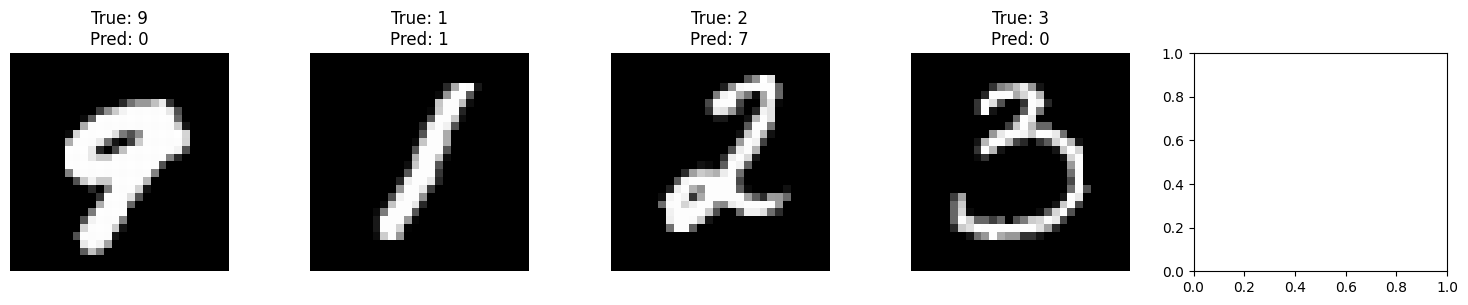

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions(model, test_loader, num_images=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images[:num_images]
    labels = labels[:num_images]

    with torch.no_grad():
        images = images.to(device)
        outputs = model(images.view(images.shape[0], -1))
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, (image, label, prediction) in enumerate(zip(images, labels, predicted)):
        axes[i].imshow(image.cpu().squeeze(), cmap='gray')
        axes[i].set_title(f"True: {label.item()}\nPred: {prediction.item()}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
visualize_predictions(model, test_loader)

Setelah melakukan uji coba dengan melakukan visualisasi dan beberapa test lainnya.. kemudian model kami simpan dengan nama "qcnn_mnist_model.pth"

In [ ]:
torch.save(model.state_dict(), 'qcnn_mnist_model.pth')

NameError: name 'torch' is not defined